<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter14/Siamese_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Extracted from Modern Computer Vision with Pytorch

In [1]:
#!pip install -q torch_snippets
from torch_snippets import *
#!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
#!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import random
from torchvision import transforms, models

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [3]:
!nvidia-smi

Sat Dec 11 23:34:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.11       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:05:00.0  On |                  N/A |
| 51%   43C    P8    N/A /  75W |    769MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os

if os.name == 'nt':
    '''
    Verify if the os is windows because some function in torch_snippets can be used only in unix archicterure. 
    '''
    def parent(fpath):
        out = '\\'.join(str(fpath).split('\\')[:-1])
        if out == '': return '.\\'
        else:         return out

    def fname(fpath):
        return fpath.split('\\')[-1]

# Corel Dataset

### Loading the Corel DataSet <br>
After load the dataset use the previous data argumentation and preprocessing

In [8]:
folder   = './images/corel/'
nclasses = 6 
file_ext   = "*.png"  
batchsize = 12

In [9]:
train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

fileset = Glob(folder+file_ext) # it returns a list of filenames
num_train_samples = int(len(fileset)*train_perc)
num_valid_samples = int(len(fileset)*valid_perc)  
num_test_samples  = len(fileset) - num_train_samples - num_valid_samples 
from random import shuffle, seed; seed(10);
shuffle(fileset)
trainset = fileset[:num_train_samples]
validset = fileset[num_train_samples:num_train_samples+num_valid_samples]
testset  = fileset[num_train_samples+num_valid_samples:]

2021-12-11 15:32:36.737 | INFO     | torch_snippets.paths:inner:24 - 355 files found at ./images/corel/*.png


In [10]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0, fillcolor=None, resample=None),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

class DatasetImage(Dataset): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        if os.name == 'nt':
            self.targets   = [int(str(x).split("\\")[-1].split("_")[0])-1 for x in self.dataset]
        else:
            self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target)    

In [11]:
def GetBatches(dataset, batchsize, transformation):
    datatensor = DatasetImage(dataset, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(trainset, batchsize, prep)  
validload = GetBatches(validset, batchsize, prep)
testload  = GetBatches(testset, batchsize, prep) 

### Network to Corel dataset <br>
This network need to be recive a example for each class, and the idea is product a feature space where the distance between them increses. <br>
So the loss need to find to get the biggest distance between the sample and all others.

After traing the constrative model, save the model and use like a feature exctacter to training a classifier (only dense layers)

In [12]:
class CorelNetworkDataLoad(Dataset):

    def __init__(self, dataset, transform=None, should_invert=True):
        self.folder = folder
        self.items = dataset
        self.transform = transform
        
    def __getitem__(self, ix):
        
        #List with label selecteds
        list_labels_in_training = []
        
        #List of images selects by our labels
        list_samples = []
        
        itemA = self.items[ix]
        labelA = int(str(itemA).split('\\')[2].split('_')[0])-1
        
        while len(list_labels_in_training) < nclasses:
            i = choose(trainset)
            sample_label = int(str(i).split('\\')[2].split('_')[0])-1
            if sample_label not in list_labels_in_training:
                list_samples.append(i)
                list_labels_in_training.append(sample_label)
                
        list_labels_in_training.insert(0, labelA)

        list_images = []
        list_images.append(Image.open(itemA))
#         print(list_images[0].shape)
        
        for image in list_samples:
            list_images.append(Image.open(image))
            
        transformed_images = []
        for readed_image in list_images:
#             readed_image = np.dstack([readed_image, readed_image, readed_image])
            if self.transform:
                transformed_images.append(self.transform(readed_image))
            else:
                transformed_images.append(readed_image)           
                
        return transformed_images, list_labels_in_training
    def __len__(self):
        return len(self.items)

In [13]:
def convBlock(ni, no):
    return nn.Sequential(
        #nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, bias=False), #, padding_mode='reflect'),
        nn.BatchNorm2d(no),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
    )

In [14]:
class CorelNetwork(nn.Module):
    def __init__(self):
        super(CorelNetwork, self).__init__()        
        self.features = nn.Sequential(
            convBlock(3,16),
            convBlock(16,128),
            convBlock(128,256),
            nn.Flatten(),
            nn.Linear(256*9*9, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )

    def forward(self, data):
        list_outputs = []
        for input_data in data:
            input_data = torch.stack(input_data)
            list_outputs.append(self.features(input_data.to(device)))
        
        return list_outputs

### My N pair loss implemetation (don't work for some reason =/) <br>
The ideia is follow the equation bellow and return the loss like the implemetation in the paper

\begin{aligned}
-\log\frac{\exp(f(\mathbf{x})^\top f(\mathbf{x}^+))}{\exp(f(\mathbf{x})^\top f(\mathbf{x}^+)) + \sum_{i=1}^{N-1} \exp(f(\mathbf{x})^\top f(\mathbf{x}^-_i))}
\end{aligned}

In [15]:
def multi_pair_loss(list_images, list_labels):
    """
    list_images = model_return
    The batch size define how many times this functios will be applyed (summing the values intering the list)
    in the final return the cum sum of this interation.
    """
    total_batches_loss = 0
    total_second_ter = torch.tensor(1)
    
    #Size of the batch (how many times the loss will be computed and summed)
    batches = list_labels[0].size(0)
    
    #Separing the data by labels
    
    #Loop for interant in all batchs
    for batch_idx in range(batches):
        #List with images that have different class the principal image
        other_class = []
        
        #Loop for all samples in each batch
        for sample_idx in range(1, len(list_labels)-1):
            
            #Verify if the tensor is the anchor or another class
            #The index are + 1, because the first image are the principal
            if list_labels[sample_idx][batch_idx] == list_labels[batch_idx][0]:
                anchor = list_images[sample_idx+1][batch_idx]
            else:
                other_class.append(list_images[sample_idx+1][batch_idx])
            
        #Calculing the Loss
        princial_image = list_images[0][batch_idx]
        
        first_ter = torch.exp(torch.matmul(princial_image.T, anchor))
        
        for term in other_class:
            total_second_ter = torch.add(total_second_ter, torch.exp(torch.matmul(princial_image.T, term)))
        
        multi_loss = -torch.log(torch.div(first_ter, (first_ter + total_second_ter)))
        
        total_batches_loss += multi_loss
        

    acc = ((first_ter > contrastive_thres) == 1).float().mean()
    return torch.div(torch.sum(total_batches_loss), batches), acc

### Github N pair loss impemetation <br>
https://github.com/leeesangwon/PyTorch-Image-Retrieval/blob/public/losses.py <br>
This implemetation vanishin the gradient (loss become to small even changing  the l2 value)

In [16]:
class NPairLoss_git(nn.Module):
    """
    N-Pair loss
    Sohn, Kihyuk. "Improved Deep Metric Learning with Multi-class N-pair Loss Objective," Advances in Neural Information
    Processing Systems. 2016.
    http://papers.nips.cc/paper/6199-improved-deep-metric-learning-with-multi-class-n-pair-loss-objective
    """

    def __init__(self, l2_reg=0.02):
        super(NPairLoss, self).__init__()
        self.l2_reg = l2_reg

    def forward(self, embeddings, target):
        n_pairs, n_negatives = self.get_n_pairs(target)

        if embeddings.is_cuda:
            n_pairs = n_pairs.cuda()
            n_negatives = n_negatives.cuda()

        anchors = embeddings[n_pairs[:, 0]]    # (n, embedding_size)
        positives = embeddings[n_pairs[:, 1]]  # (n, embedding_size)
        negatives = embeddings[n_negatives]    # (n, n-1, embedding_size)

        losses = self.n_pair_loss(anchors, positives, negatives) \
            + self.l2_reg * self.l2_loss(anchors, positives)

        return losses

    @staticmethod
    def get_n_pairs(labels):
        """
        Get index of n-pairs and n-negatives
        :param labels: label vector of mini-batch
        :return: A tuple of n_pairs (n, 2)
                        and n_negatives (n, n-1)
        """
        labels = labels.cpu().data.numpy()
        n_pairs = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            anchor, positive = np.random.choice(label_indices, 2, replace=False)
            n_pairs.append([anchor, positive])

        n_pairs = np.array(n_pairs)

        n_negatives = []
        for i in range(len(n_pairs)):
            negative = np.concatenate([n_pairs[:i, 1], n_pairs[i+1:, 1]])
            n_negatives.append(negative)

        n_negatives = np.array(n_negatives)

        return torch.LongTensor(n_pairs), torch.LongTensor(n_negatives)

    @staticmethod
    def n_pair_loss(anchors, positives, negatives):
        """
        Calculates N-Pair loss
        :param anchors: A torch.Tensor, (n, embedding_size)
        :param positives: A torch.Tensor, (n, embedding_size)
        :param negatives: A torch.Tensor, (n, n-1, embedding_size)
        :return: A scalar
        """
        anchors = torch.unsqueeze(anchors, dim=1)  # (n, 1, embedding_size)
        positives = torch.unsqueeze(positives, dim=1)  # (n, 1, embedding_size)

        x = torch.matmul(anchors, (negatives - positives).transpose(1, 2))  # (n, 1, n-1)
        x = torch.sum(torch.exp(x), 2)  # (n, 1)
        loss = torch.mean(torch.log(1+x))
        return loss

    @staticmethod
    def l2_loss(anchors, positives):
        """
        Calculates L2 norm regularization loss
        :param anchors: A torch.Tensor, (n, embedding_size)
        :param positives: A torch.Tensor, (n, embedding_size)
        :return: A scalar
        """
        return torch.sum(anchors ** 2 + positives ** 2) / anchors.shape[0]
    

### The loss function that used in the corel <br>
This function recives the return of model and their labels, to calculate the loss defined in variable nloss and cossine similarity to the accuracy.

In [17]:
def multi_pair_loss2(list_images, list_labels):
    """
    list_images = model_return
    The batch size define how many times this functios will be applyed (summing the values intering the list)
    in the final return the cum sum of this interation.
    """
    #The total of all batchs, after the sun the value is / by the batch size
    total_batches_loss = 0
    total_distance = 0
    
    coss_distance = distances.CosineSimilarity()
    
    #Size of the batch (how many times the loss will be computed and summed)
    batches = list_labels[0].size(0)
    
    # list_labels_in_training = torch.stack(list_labels_in_training)
    
    #Loop for interant in all batchs
    for batch_idx in range(batches):
        #List with images that have different class the principal image

#         print('batch_idx:', batch_idx)
#         print('list_images:', list_images.shape)
#         print('list_labels:', len(list_labels))
        total_batches_loss += nloss(list_images[batch_idx], list_labels[batch_idx])
        total_distance += coss_distance(list_images[batch_idx], list_images[batch_idx])
        
    acc = ((total_distance > contrastive_thres) == 1).float().mean()
#     print(f'Rodada: \n')
    return torch.div(torch.sum(total_batches_loss), batches), acc

In [19]:
from pytorch_metric_learning import losses
from pytorch_metric_learning import distances

In [20]:
#Tested loss in the network

# nloss = NPairLoss(l2_reg=0.2)
nloss = losses.NTXentLoss(temperature=0.07)
# nloss = losses.NPairsLoss()

In [24]:
def reshape_data(transformed_images):
    """
    Recive a list [Samples, Batch size] and convert to [Batch size, Samples],
    this transformation helps to use a loop to compute the loss for each batch.
    """
    
    list_of_samples = []
    for batch in range(len(transformed_images[0])):
        temp_list = []
        for sample in transformed_images:
            temp_list.append(sample[batch])

        list_of_samples.append(temp_list)
        
    return list_of_samples

In [25]:
#Create the data separation
trn_corel_ds = CorelNetworkDataLoad(trainset, transform=aug)
val_corel_ds = CorelNetworkDataLoad(validset, transform=prep)

In [26]:
#The dataloader to corel, works is set to 0 because more that give me ROM error
corel_trn_dl = DataLoader(trn_corel_ds, batch_size=batchsize, num_workers=0)
corel_val_dl = DataLoader(val_corel_ds, batch_size=batchsize, num_workers=0)

In [27]:
#Seting the variables to training
contrastive_thres = 1/nclasses
corel_model = CorelNetwork().to(device)
optimizer = torch.optim.Adam(corel_model.parameters(), lr=1e-4)
criterion = multi_pair_loss2

In [40]:
def train_batch(model, data, optimizer, criterion):
    
    #Get data from dataloader
    transformed_images, list_labels_in_training = [t for t in data]
    
    #Reshape the data to format accpet to the loss (batchsize, number_of_samples)
    transformed_images = reshape_data(transformed_images)
    list_labels_in_training = reshape_data(list_labels_in_training)
    
    #Set the gradient
    optimizer.zero_grad()

    #Get the feature space from samples
    model_return = model(transformed_images)

    #Convert the list os return in a single tensor of tensor
    model_return = torch.stack(model_return)
    list_labels_in_training = torch.stack([torch.stack(item) for item in list_labels_in_training])

    #Evalute the loss and acc of this step
    loss, acc = criterion(model_return, list_labels_in_training)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    
    #Get data from dataloader
    transformed_images, list_labels_in_training = [t for t in data]
    
    #Reshape the data to format accpet to the loss (batchsize, number_of_samples)
    transformed_images = reshape_data(transformed_images)
    list_labels_in_training = reshape_data(list_labels_in_training)
    
    #Get the feature space from samples
    model_return = model(transformed_images)

    model_return = torch.stack(model_return)
    list_labels_in_training = torch.stack([torch.stack(item) for item in list_labels_in_training])

    loss, acc = criterion(model_return, list_labels_in_training)
    return loss.item(), acc.item()

https://kevinmusgrave.github.io/pytorch-metric-learning/distances/#dotproductsimilarity <br>
https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#npairsloss

In [41]:
#The training process
torch.cuda.empty_cache()
n_epochs = 50
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(corel_trn_dl)
    for i, data in enumerate(corel_trn_dl):
        loss, acc = train_batch(corel_model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
        
    N = len(corel_val_dl)
    for i, data in enumerate(corel_val_dl):
        loss, acc = validate_batch(corel_model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

EPOCH: 20.000	trn_loss: 0.043	trn_acc: 0.731	val_loss: 0.224	val_acc: 0.642	(794.99s - 1192.49s remaining)
EPOCH: 40.000	trn_loss: 0.027	trn_acc: 0.687	val_loss: 0.179	val_acc: 0.950	(1522.92s - 380.73s remaining)
EPOCH: 50.000	val_loss: 0.012	val_acc: 0.347	(1881.73s - 0.00s remaining)))

100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 2287.85it/s]


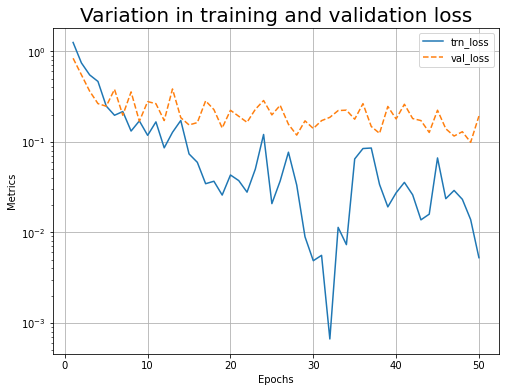

In [42]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')

100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 2475.16it/s]


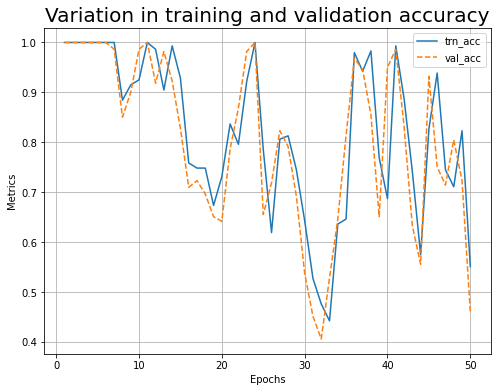

In [43]:
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

### Testing the contrastive model for Corel dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


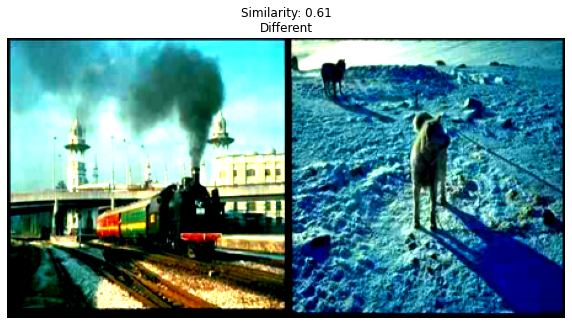

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


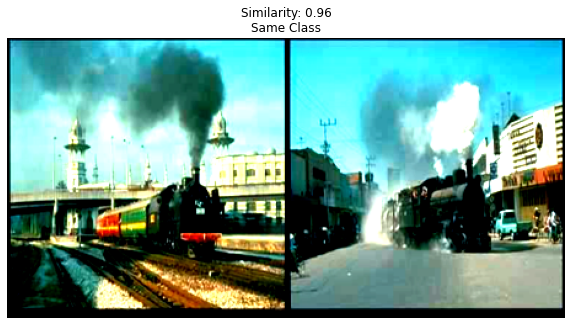

In [59]:
cos = nn.CosineSimilarity(dim=-1, eps=1e-6)

corel_model.eval()
val_corel_dl = DataLoader(val_corel_ds,num_workers=0,batch_size=1,shuffle=True)
data = next(iter(val_corel_dl))

#Get and eshape the data from dataset
transformed_images, list_labels_in_training = [t for t in data]
transformed_images = reshape_data(transformed_images)

#Loop for get two samples and compare with x0
for i in range(2):

    #Set the images that will by compared
    x0 = transformed_images[0][0]
    x1_index = choose(range(len(transformed_images[0])))
    x1 = transformed_images[0][x1_index]
    
    #Concat the information of samples (x0 the principal image
    #and x1 the image to compare the similarity)
    concatenated = torch.stack((x0*0.5+0.5, x1*0.5+0.5),0)
    
    #Generate the feature space
    result = corel_model(transformed_images)
    
    #Set the feature space to variable
    output1 = result[0][0]
    output2 = result[0][x1_index]
    
    #Measure the difference between the outputs of network
    cossine_similarity = cos(output1, output2)
    output = 'Same Class' if cossine_similarity.item() >= 1-contrastive_thres else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Similarity: {:.2f}\n{}'.format(cossine_similarity.item(), output))
    plt.show()

In [60]:
#save the model
torch.save(corel_model.state_dict(),'model_Corel_v3')

### Training a classifier with constrative model like bakebone

In [41]:
from torchsummary import summary

In [42]:
#Load the network trained
def read_model(path, model_type):
    model = model_type
    model.load_state_dict(torch.load(path))
#     model.eval()
    return model

In [43]:
#Set the network to device, and set the eval method.
loaded_corel_model = read_model('model_Corel_v3',CorelNetwork())
loaded_corel_model.to(device)
loaded_corel_model.eval()
# summary(loaded_corel_model, (12,3,224,224))

CorelNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=

In [44]:
#Network to classifie using the data from backbone
dnn_corel = nn.Sequential(
    nn.Sequential(nn.Linear(64, nclasses))
)
dnn_corel.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [46]:
#The batch to trainin the classical classifier network

def train_batch_dnn(model, backbone, data, optimizer, criterion):
    transformed_images, list_labels_in_training = [t for t in data]
    optimizer.zero_grad()
    transformed_images = reshape_data(transformed_images)
    list_labels_in_training = reshape_data(list_labels_in_training)
    backbone_return = backbone(transformed_images)
    model_return = model(backbone_return[0])
#     print('model_return:', model_return)
    loss = criterion(model_return, torch.tensor(list_labels_in_training[0]).to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch_dnn(model, backbone, data, criterion):
    transformed_images, list_labels_in_training = [t for t in data]
    transformed_images = reshape_data(transformed_images)
    list_labels_in_training = reshape_data(list_labels_in_training)
    backbone_return = backbone(transformed_images)
    model_return = model(backbone_return[0])
    loss = criterion(model_return, torch.tensor(list_labels_in_training[0]).to(device))
    return loss.item()


In [47]:
torch.cuda.empty_cache()
n_epochs = 50
log = Report(n_epochs)

dnn_corel.to(device)
optimizer = torch.optim.Adam(dnn_corel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

backbone = loaded_corel_model
backbone.to(device)

for epoch in range(n_epochs):
    N = len(corel_trn_dl)
    for i, data in enumerate(corel_trn_dl):
        loss = train_batch_dnn(dnn_corel, backbone, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, end='\r')
    N = len(corel_val_dl)
    for i, data in enumerate(corel_val_dl):
        loss = validate_batch_dnn(dnn_corel, backbone, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

EPOCH: 20.000	trn_loss: 0.106	val_loss: 0.094	(657.87s - 986.81s remaining)
EPOCH: 40.000	trn_loss: 0.049	val_loss: 0.047	(1331.73s - 332.93s remaining)
EPOCH: 50.000	val_loss: 0.023	(1691.23s - 0.00s remaining)))

In [19]:
torch.cuda.empty_cache()
n_epochs = 100
log = Report(n_epochs)

dnn_corel.to(device)
optimizer = torch.optim.Adam(dnn_corel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

backbone = loaded_corel_model
backbone.to(device)

for epoch in range(n_epochs):
    N = len(corel_trn_dl)
    for i, data in enumerate(corel_trn_dl):
        loss = train_batch_dnn(dnn_corel, backbone, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, end='\r')
    N = len(corel_val_dl)
    for i, data in enumerate(corel_val_dl):
        loss = validate_batch_dnn(dnn_corel, backbone, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

EPOCH: 20.000	trn_loss: 0.875	val_loss: 1.054	(931.97s - 3727.89s remaining)
EPOCH: 40.000	trn_loss: 0.857	val_loss: 0.873	(1857.65s - 2786.47s remaining)
EPOCH: 60.000	trn_loss: 0.789	val_loss: 0.789	(2784.77s - 1856.51s remaining)
EPOCH: 80.000	trn_loss: 0.764	val_loss: 1.103	(3780.56s - 945.14s remaining)
EPOCH: 100.000	trn_loss: 0.798	val_loss: 0.937	(4817.30s - 0.00s remaining)


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 1499.34it/s]


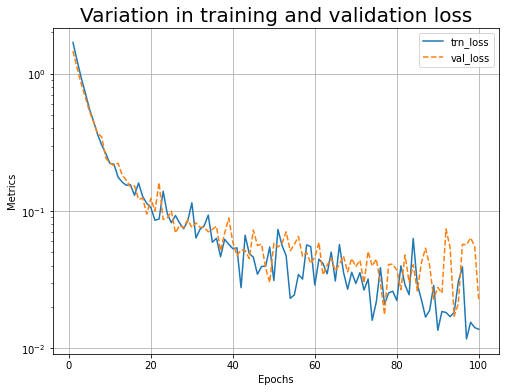

In [48]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')

In [65]:
#Save the classifier model
torch.save(dnn_corel.state_dict(),'dnn_model_Corel_v3')

In [49]:
dnn_corel.eval()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [62]:
#Code to compute de acc in the test data
def accuracy(x, y, model, nclasses):
        prediction = model(x)
        y = torch.tensor(y).squeeze().to(device)
        is_correct = (torch.max(prediction, 1)[1] == y) # verify if the returned indices from torch.max 
                                                        # are the same in y, creating a list with 
                                                        # the boolean results
                  
        return(is_correct.cpu().numpy().tolist())
    
def test(model, test_batches, loss_fn, nclasses):
    #put model in evaluation mode
    model.eval()

    Acc = []
    
    #process all batches
    for ix, data in enumerate(corel_test_dl):
        transformed_images, list_labels_in_training = data
        
        transformed_images = reshape_data(transformed_images)
        list_labels_in_training = reshape_data(list_labels_in_training)

        transformed_images = transformed_images
        
        #Get the feature space from the backbone and calculate the accuracy
        with torch.no_grad():
            backbone_return = backbone(transformed_images)
            Acc.extend(accuracy(backbone_return[0], list_labels_in_training[0], model, nclasses))
    
    return(np.mean(Acc)) 

In [63]:
#Create the test data set and dataloader
test_corel_ds = CorelNetworkDataLoad(testset, transform=prep)
corel_test_dl = DataLoader(test_corel_ds, shuffle=True, batch_size=12, num_workers=0)

In [64]:
#Calculate the acc of the classifier trained with contrastive backbone.
acc = test(dnn_corel, corel_test_dl, criterion, nclasses)
print('Acc: {:.6f}'.format(np.mean(acc)))

Acc: 1.000000
